In [1]:
import sys
# add your path to the current repo
sys.path.append('/lustre/groups/peng/projects/aidin_Kenjis_project/')
sys.path.append('/lustre/groups/peng/projects/aidin_Kenjis_project/data_from_CTG_assay/')
sys.path.append('/lustre/groups/peng/projects/aidin_Kenjis_project/batch_effect_removal/')
sys.path.append('/home/aidin/Documents/tum_courses/master_thesis/code_cleaning/CellDeathPred/')

In [2]:
sys.path

['/home/aidin/Documents/tum_courses/master_thesis/code_cleaning/CellDeathPred/notebooks',
 '/home/aidin/miniconda3/envs/alivex_env/lib/python310.zip',
 '/home/aidin/miniconda3/envs/alivex_env/lib/python3.10',
 '/home/aidin/miniconda3/envs/alivex_env/lib/python3.10/lib-dynload',
 '',
 '/home/aidin/miniconda3/envs/alivex_env/lib/python3.10/site-packages',
 '/lustre/groups/peng/projects/aidin_Kenjis_project/',
 '/lustre/groups/peng/projects/aidin_Kenjis_project/data_from_CTG_assay/',
 '/lustre/groups/peng/projects/aidin_Kenjis_project/batch_effect_removal/',
 '/home/aidin/Documents/tum_courses/master_thesis/code_cleaning/CellDeathPred/']

In [3]:
import pandas as pd
import numpy as np

# load model

In [1]:
from main import parse_args

# https://stackoverflow.com/questions/24000444/mock-command-line-arguments-for-python-script-with-optparse
sys.argv = ['main', '-m', 'test', 
           '--data', '/lustre/groups/peng/datasets/kenji/',
            #'--load', '/home/icb/aidin.biibosunov/projects/kaggle_cellular_image_classif/kaggle-rcic-1st/results/dn161_1.129',
           #'--save', './results/stain1_arcface',
           
            #'--stain', '2',
           '--batch_size', '32',
           '--bn_mom', '0.6',
            '--classes', '3',
            '--cv-number', '-1', # -1 means val ds is empty
            '--tta', '0', # disable tta 
            '--tta-size', '1', 
            '--zone', 'medium',
           '--seed', '0', 
           '--embedding_size', '1280',
           #'--embedding_size', '512',
           '--backbone', 'efficientnet_b0',
           #'--backbone', 'resnet18',
           '--crop', 'True',
           '--avg_embs', 'True',
           #'--train_plates', '1,3',
           ]

#del sys
print(sys.argv)
args = parse_args()

ModuleNotFoundError: No module named 'main'

In [21]:
import torch
import torchvision
import torchvision.models as models
from torch.nn import functional as F
from torch import nn
from torchvision import transforms

from model import Backbone, Embedder, Classifier
from test_with_classifier_crop_hcs import TestWithClassifierCropHCS

import pytorch_metric_learning.utils.logging_presets as logging_presets
import pytorch_metric_learning

In [22]:
trunk = Backbone(backbone=args.backbone, stain = args.stain,bn_mom = args.bn_mom) 

embedder = Embedder(num_features=trunk.features_num, embedding_size=args.embedding_size, bn_mom=args.bn_mom, emb_hidden = None, disable_emb = True)
#embedder = Embedder(num_features=trunk.features_num, embedding_size=args.embedding_size, bn_mom=args.bn_mom, emb_hidden = [512], disable_emb = False)
#embedder = torch.nn.Identity()

#'''
classifier = Classifier(embedding_size=args.embedding_size,
                        classes=args.classes,
                        head_hidden=args.head_hidden,
                        bn_mom = args.bn_mom)
#'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#saved_models_train_exp67_2 49 #train plates 1,2,5,6,7,8,10; range2 metric 0.5 + ce 0.5; efficientnet_b0
path_models = 'saved_models_train_exp67_2'
best_checkpoint = 49

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    trunk = nn.DataParallel(trunk)
    embedder = nn.DataParallel(embedder)
    classifier = nn.DataParallel(classifier)
    
    checkpoint_trunk = torch.load(f"../saved_models/{path_models}/trunk_best{best_checkpoint}.pth")
    checkpoint_embedder = torch.load(f"../batch_effect_removal/{path_models}/embedder_best{best_checkpoint}.pth")
    checkpoint_classifier = torch.load(f"./{path_models}/classifier_best{best_checkpoint}.pth")

    trunk.module.load_state_dict(checkpoint_trunk)
    embedder.module.load_state_dict(checkpoint_embedder)
    classifier.module.load_state_dict(checkpoint_classifier)

    trunk.to(device);
    embedder.to(device);
    classifier.to(device);
else:
    print("Let's use", "CPU!")
    trunk.load_state_dict(torch.load(f"../saved_models/{path_models}/trunk_best{best_checkpoint}.pth", map_location=device))
    embedder.load_state_dict(torch.load(f"../saved_models/{path_models}/embedder_best{best_checkpoint}.pth", map_location=device))
    classifier.load_state_dict(torch.load(f"../saved_models/{path_models}/classifier_best{best_checkpoint}.pth", map_location=device))

Let's use CPU!


# calculate embeddings

In [ ]:
# importing the dataset
# here dataset_exp8 corresponds to experiment 3 from the paper
from dataset_exp8 import CellularDatasetNew8
train_transform = transforms.Compose([
                                        transforms.RandomHorizontalFlip(0.5),
                                        transforms.RandomVerticalFlip(0.5)])
ds_exp8 = CellularDatasetNew8(root_dir='/lustre/groups/peng/datasets/kenji/', mode='train', split_seed=1, cv_number=-1, 
                            transform=train_transform, filter_fields = False, crop=True, 
                            channels = [1,2,3,4], select_plates=[1,2,3], choose_range = 'all',
                             confocal=True, magnification='40x', zoom20_40=False)

In [84]:
df_exp8 = pd.DataFrame(ds_exp8.data, columns = ['row', 'column', 'drug_name', 'concentrat','atp', 'field', 'plate', 'drug', 'drug_type_encoded'])

In [85]:
df_exp8

,row,column,drug_name,concentrat,atp,field,plate,drug,drug_type_encoded
0,2,1,DMSO,0.0,1.010063,1,1,healthy,2
1,2,1,DMSO,0.0,1.010063,2,1,healthy,2
2,2,1,DMSO,0.0,1.010063,3,1,healthy,2
3,2,1,DMSO,0.0,1.010063,4,1,healthy,2
4,2,1,DMSO,0.0,1.010063,5,1,healthy,2
...,...,...,...,...,...,...,...,...,...
10075,15,24,Untreated,0.0,0.915215,6,3,healthy,2
10076,15,24,Untreated,0.0,0.915215,7,3,healthy,2
10077,15,24,Untreated,0.0,0.915215,8,3,healthy,2
10078,15,24,Untreated,0.0,0.915215,9,3,healthy,2


In [86]:
drug_dict = {'DMSO': 'healthy', 'Untreated': 'healthy', 'untreated': 'healthy', 'Actinomycin D': 'apoptosis', 'Vinblastine': 'apoptosis', 
                                                                                       'Vinblastin': 'apoptosis', 'Paclitaxel': 'apoptosis', 'Staurosporine': 'apoptosis',
                                                             'Stauro': 'apoptosis','Etoposide': 'apoptosis',
                                                                   'Doxorubicin': 'apoptosis','Niclosamide': 'apoptosis',
                                                                                      'Erastin': 'ferroptosis', 'FIN56': 'ferroptosis', 'FINO2': 'ferroptosis', 
                                                                                       'IKE': 'ferroptosis', 'ML162': 'ferroptosis', 'ML210': 'ferroptosis', 
                                                                                        'RLS3': 'ferroptosis', 'RSL3': 'ferroptosis'}

In [87]:
def fields_dist(l, ds_length):
    res = []
    for i in range(len(l)-1):
        dist = l[i+1] - l[i]
        res.append(dist)
    last_d = ds_length - l[-1] 
    res.append(last_d)
    return res

In [88]:
#import plotly.express as px
#import umap
from torch.utils.data import DataLoader
# Apoptosis: Staurosporine, Actinomycin D, Paclitaxel, Vinblastin  
# Ferroptosis: Erastin, FIN56, FINO2, IKE, ML162, ML210, RSL3 
def get_embeddings_24h(trunk, embedder, dataset, inducers, avg_fields = True):
    trunk.eval()
    embedder.eval()
    
    test_df = pd.DataFrame(dataset.data, columns = ['row', 'column', 'drug', 'concentrat','atp', 'field', 'plate', 'drug_type', 'drug_type_encoded'])
    print(dataset.__len__())
    ds_len = dataset.__len__()
    loader = DataLoader(
        dataset, batch_size = 24, shuffle=False,
        num_workers=6)
    
    embeddings = []
    labls = []
    wells = {}
    well_index = []
    
    if avg_fields:
        for i, (X, field, I , row, col, plate, Y) in enumerate(loader):
            well_pos = list(zip(plate.tolist(), row.tolist(), col.tolist()))
            indexes = [well_pos.index(x) for x in list(dict.fromkeys(well_pos))] # index of first occurence 
            for pos in range(len(list(dict.fromkeys(well_pos)))):
                k = tuple(list(dict.fromkeys(well_pos)))[pos]
                if k not in wells.keys():
                    wells[k] = indexes[pos] 
                    well_index.append(I[indexes[pos]].item())
            labls.append(Y)
            X = X.to(device)
            bs, ncrops, c, h, w = X.size()
            with torch.no_grad():
                embeds = embedder.module.forward(trunk.module.forward(X.view(-1,c,h,w))).view(bs,ncrops,-1).mean(1)
            embeds_normal = torch.nn.functional.normalize(embeds)
            embeddings.append(embeds_normal)
        
        embs = torch.cat(embeddings,dim=0)
        labels = torch.cat(labls,dim=0)

        fields_d = fields_dist(well_index, ds_len)
        embs_well = torch.split(embs, fields_d)
        
        embs_final = [torch.nn.functional.normalize(torch.mean(emb, dim=0, keepdim=True)).cpu().numpy() for emb in embs_well]
        #embs_final = torch.cat(embs_avg_fields,dim=0).cpu()

        # taking only information from one field per well
        test_df = test_df.iloc[well_index].reset_index(drop=True, inplace=False)
    else:
        for i, (X, field, I , row, col, plate, Y) in enumerate(loader):
            #print (I)
            labls.append(Y)
            X = X.to(device)
            #print (X.size())
            bs, ncrops, c, h, w = X.size()
            with torch.no_grad():
                #embeds = embedder(X) # (10,1000)
                embeds = embedder.module.forward(trunk.module.forward(X.view(-1,c,h,w))).view(bs,ncrops,-1).mean(1)
                #embeds = embedder.module.forward(trunk.module.forward(X))
            #embeds_avg = torch.mean(embeds,dim=0, keepdim=True) #1000
            #if normalize_embeddings:
            embeds_normal = torch.nn.functional.normalize(embeds)
            embeddings.append(embeds_normal)

        embs_final = torch.cat(embeddings,dim=0).cpu()
        embs_final_np = embs_final.numpy()
        embs_final = embs_final_np.tolist()
        
        labels = torch.cat(labls,dim=0)

    decoded_labels_df = pd.DataFrame({'drug': test_df['drug']})
    decoded_labels_df['ground_truth_labels'] = test_df['drug_type_encoded']
    decoded_labels_df['concentration'] = test_df['concentrat']
    decoded_labels_df['plate'] = test_df['plate']
    decoded_labels_df['drug_name'] = test_df['drug']
    decoded_labels_df['field'] = test_df['field']
    decoded_labels_df['atp'] = test_df['atp']
    decoded_labels_df['embs'] = embs_final
    
    if (inducers != 'apoptosis' and inducers != 'ferroptosis'):
        decoded_labels_df['drug'] = decoded_labels_df['drug'].map(drug_dict)
    #return embs_final, decoded_labels_df
    return decoded_labels_df

In [89]:
embs_df = get_embeddings_24h(trunk, embedder, ds_exp8, inducers = 'healthy', avg_fields = False)

10080


In [34]:
embs_df.shape

(10080, 8)

In [90]:
embs_df.to_csv(f'./embs_exp8_{path_models}_all_confocal40.csv')

# testing accuracy with classifier

In [13]:
def fields_dist(l, ds_length):
    res = []
    for i in range(len(l)-1):
        dist = l[i+1] - l[i]
        res.append(dist)
    last_d = ds_length - l[-1] 
    res.append(last_d)
    return res

In [19]:
@torch.no_grad()
def infer(args, trunk,embedder, classifier, dataset, device, avg_fields):
    """Infer and return prediction in dictionary formatted {sample_id: logits}"""
    test_df = pd.DataFrame(dataset.data, columns = ['row', 'column', 'drug', 'concentrat', 'atp', 'field', 'plate', 'drug_type', 'drug_type_encoded'])
    print(dataset.__len__())
    ds_len = dataset.__len__()
    loader = DataLoader(dataset, batch_size = 24, shuffle=False, num_workers=6)
    
    res = {}
    
    trunk.eval()
    embedder.eval()
    classifier.eval()
    
    if avg_fields:
        logits_list = []
        labls = []
        wells = {}
        well_index = []
        for i, (X, field, I , row, col, plate, Y) in enumerate(loader):
            well_pos = list(zip(plate.tolist(), row.tolist(), col.tolist()))
            indexes = [well_pos.index(x) for x in list(dict.fromkeys(well_pos))] # index of first occurence 
            for pos in range(len(list(dict.fromkeys(well_pos)))):
                k = tuple(list(dict.fromkeys(well_pos)))[pos]
                if k not in wells.keys():
                    wells[k] = indexes[pos] 
                    well_index.append(I[indexes[pos]].item())
            labls.append(Y)
            X = X.to(device)
            bs, ncrops, c, h, w = X.size()
            with torch.no_grad():
                #embeds = embedder.module.forward(trunk.module.forward(X.view(-1,c,h,w))).view(bs,ncrops,-1).mean(1)
                logit = classifier.module.forward(embedder.module.forward(trunk.module.forward(X.view(-1, c, h, w)))).view(bs, ncrops, -1).mean(1) # avg logits
            #logits = torch.stack(logit).cpu()
            #embeds_normal = torch.nn.functional.normalize(embeds)
            #torch.cuda.empty_cache()
            logits_list.append(logit)

        logits = torch.cat(logits_list,dim=0)
        labels = torch.cat(labls,dim=0)

        #print ('labels', labels)
        #print ('labels', labels.shape)

        fields_d = fields_dist(well_index, ds_len)
        logits_well = torch.split(logits, fields_d)
        logits_avg_fields = [torch.nn.functional.normalize(torch.mean(logit, dim=0, keepdim=True)).cpu() for logit in logits_well]
        predictions_avg_fields = [torch.argmax(logit).cpu().numpy() for logit in logits_avg_fields]
        logits_final = torch.cat(logits_avg_fields,dim=0).cpu()

        # taking only information from one field per well
        test_df = test_df.iloc[well_index].reset_index(drop=True, inplace=False)
        #decoded_labels_df = pd.DataFrame({'drug': test_df['drug']})
        #res['ground_truth_labels'] = test_df['drug_type_encoded'] 
        #res[''] = test_df['drug_type_encoded'] 

        res_df = pd.DataFrame({'ground_truth_labels': test_df['drug_type_encoded']})
        res_df['plate'] = test_df['plate']
        #res_df['well'] = test_df['wellname']
        res_df['drugs'] = test_df['drug']
        #res_df['logits_final'] = logits_avg_fields
        res_df['predicted_labels'] = predictions_avg_fields
        return res_df

    #for i, (X, _, f, I , plate, row,col, Y) in enumerate(loader):
    for i, (X, f, I , row, col, plate, Y) in enumerate(loader):
        X = X.to(device)
        Xs = [X]
        bs, ncrops, c, h, w = X.size()
        ys = [classifier.module.forward(embedder.module.forward(trunk.module.forward(X.view(-1, c, h, w)))).view(bs, ncrops, -1).mean(1) for X in Xs] # avg logits
        y = torch.stack(ys).mean(0).cpu()

        for j in range(len(I)):
            assert I[j].item() not in res
            res[I[j].item()] = f[j].numpy(), y[j].numpy(), plate[j].numpy()
    
    return res

In [20]:
def subset_fields(res_list, num_fields = 8):
    res = []
    for i in range(0, len(res_list) - 1, num_fields):
        res.append([res_list[i], res_list[i + 1]])
    return res

In [21]:
def fields_agg(res_list, num_fields, agg_f = 'mean'):
    res = []
    for i in range(0, len(res_list), num_fields):
        fields = [x for x in res_list[i:i + num_fields]] #subset fields
        if agg_f == 'mean':
            avg_f = np.mean(fields, axis = 1)
        else:
            avg_f = np.median(fields, axis = 1)
        res.append(avg_f)
    return res

In [34]:
import importlib
from torch.utils.data import DataLoader
from dataset_exp8 import CellularDatasetNew8

def predict_test_labels(args, ds, trunk, embedder, classifier, device, prefix, path_models = path_models, treatment_classes = 3, avg_fields = False,mode='test'):
    """Return dictionary of predicted labels of the model on test set and  ground truth and accuracy"""
    cur_dataset = importlib.import_module(ds)
    transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.RandomVerticalFlip(0.5)])
    if mode == 'test':
        #dataset = cur_dataset.get_test_dataset(args, test_transform=transform, filter_fields=True, channels=[1,2,3,4])
        dataset = CellularDatasetNew8(root_dir='/lustre/groups/peng/datasets/kenji/', mode='train', split_seed=1, cv_number=-1, 
                            transform=train_transform, filter_fields = False, crop=True, 
                            channels = [1,2,3,4], select_plates=[1,2,3], choose_range = 'range2',
                             confocal=False, magnification='40x', return_original=False, zoom20_40=False)
        '''
        # option to filter out healthy wells
        query_df = pd.DataFrame(dataset.data, columns = ['row', 'column', 'drug', 'concentrat', 'field', 'plate','drug_type', 'drug_type_encoded'])
        indices_healthy = (query_df[query_df['drug_type'] == 'healthy'].index.values.tolist())
        dataset.filter(lambda i, d: i not in indices_healthy)
        '''
    else:
        # actually returns two CellularDataset types not dataloaders. Already augmented with transformations.
        dataset, val_dataset = cur_dataset.get_train_val_loader(args, train_transform=transform, val_transform=transform, filter_fields=True) # add option for dataset in args! 
    #loader = DataLoader(dataset, batch_size = 24, shuffle=False,num_workers=6)
    #with torch.cuda.amp.autocast():
    res = infer(args, trunk, embedder, classifier, dataset, device, avg_fields)
    
    #print (res)
    
    n = 0
    s = 0
    output = {}
    
    if avg_fields:
        pred =  res['predicted_labels'].tolist()
        truth =  res['ground_truth_labels'].tolist()
        acc = sum(1 for x,y in zip(pred,truth) if x == y) / len(truth)
        
        # to save
        res.to_csv(f'./saved_predictions/{mode}_{path_models}_{prefix}_on_{ds}_{acc:.2f}.csv')
        
        return res, acc
        '''
        # Predictions from different fields of a well are combined by taking mean of logits
        # assuming ordered test dataset
        num_fields = 10
        res_list = list(res.values())
        #comb_logits = subset_fields(res_list, num_fields = 8)
        #logits = np.average(comb_logits, axis = 1)
        logits = fields_agg(res_list, num_fields = num_fields, agg_f='median')
        #print (logits)
        #print (len(logits))
        #pred = np.argmax(logits)
        
        #test_loader.dataset.filter(lambda i, d: (i % (num_fields-1) == 0)) # take one img from every well
        d = loader.dataset.data[0::num_fields] # list of every num_field element [0,8,16,...] 
        #print (len(d))
        for i in range(len(logits)):
            output[i] = {}
            output[i]['prediction'] = logits[i][:treatment_classes].argmax() # cafefull with treatment_classes
            output[i]['truth'] = d[i][-1]
        
            #print (d[i])
            r = output[i]['prediction'] == d[i][-1]
            n += 1
            s += r
        
        output['acc'] = s / n if n != 0 else 0  
        return output
        '''

    for i, v in res.items():
        output[i] = {}
        d = dataset.data[i]
        output[i]['predicted_labels'] = v[1][:treatment_classes].argmax() # cafefull with treatment_classes
        output[i]['ground_truth_labels'] = d[-1]
        output[i]['plate'] = v[2]
        output[i]['treatment'] = d[2]
        output[i]['concentr'] = d[3]
        output[i]['atp'] = d[4]
        
        r = output[i]['predicted_labels'] == d[-1]
        n += 1
        s += r
        
    output['acc'] = s / n if n != 0 else 0    
    
    acc = output['acc']
    pred_df = pd.DataFrame.from_dict(output)
    # to save
    pred_df.to_csv(f'./saved_predictions/{mode}_{path_models}_{prefix}_on_{ds}_{acc:.2f}.csv')
    return output, acc

In [35]:
pred, acc = predict_test_labels(args, ds = 'dataset_exp8', trunk = trunk, embedder = embedder, classifier = classifier, device = device, 
                           treatment_classes = 3, avg_fields = False, mode='test', prefix='pl123_exp8_range2_nonconfocal40')

1116


In [ ]:
acc

In [ ]:
len(pred)

## confusion matrix

In [45]:
def create_prediction_df(pred_csv):
    pred_df = pd.read_csv(pred_csv)
    
    pred_df = pred_df.drop('acc', 1)
    pred_df = pred_df.transpose()
    pred_df = pred_df.drop('Unnamed: 0',axis=0)
    pred_df.rename(columns={0: 'predicted_labels', 1: 'ground_truth_labels', 2: 'plate', 3: 'treatment', 4: 'concentr', 5: 'atp'}, inplace=True)
    
    pred_df.reset_index(drop=True, inplace=True)
    
    pred_df['plate'] = pd.to_numeric(pred_df['plate'])
    pred_df['ground_truth_labels'] = pd.to_numeric(pred_df['ground_truth_labels'])
    pred_df['predicted_labels'] = pd.to_numeric(pred_df['predicted_labels'])
    pred_df['concentr'] = pd.to_numeric(pred_df['concentr'])
    pred_df['atp'] = pd.to_numeric(pred_df['atp'])
    
    di = {0: 'apoptosis', 1: 'ferroptosis', 2: 'healthy'}
    pred_df['truth_decoded'] = pred_df['ground_truth_labels'].map(di) 
    pred_df['prediction_decoded'] = pred_df['predicted_labels'].map(di) 
    
    return pred_df

In [36]:
from sklearn.metrics import classification_report
def create_classific_report(pred_df):
    l = ['healthy','apoptosis', 'ferroptosis']
    report = classification_report(pred_df['truth_decoded'], pred_df['prediction_decoded'], labels = l, target_names=l, output_dict=True)
    return (pd.DataFrame(report).transpose())

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

def create_confusion_matrix(pred_df, prefix, save=False):
    #di = {0: 'apoptosis', 1: 'ferroptosis', 2: 'healthy'}
    #pred_df = predict_well_class_df['prediction'].map(di) 
       
    # Apoptosis: Staurosporine, Actinomycin D, Paclitaxel, Vinblastin  
    # Ferroptosis: Erastin, FIN56, FINO2, IKE, ML162, ML210, RSL3 
    
    #l = ['Untreated','DMSO', 'Staurosporine', 'Actinomycin D', 'Paclitaxel', 'Vinblastin', 'Erastin', 'FIN56', 'FINO2', 'IKE', 'ML162', 'ML210', 'RSL3']
    l = ['healthy','apoptosis', 'ferroptosis']
    drug_confusion = confusion_matrix(pred_df['truth_decoded'], pred_df['prediction_decoded'], labels = l, normalize = 'true')
    
    drug_confusion_df = pd.DataFrame(data=drug_confusion, index=l, columns=l)
    #drug_confusion = confusion_matrix(decoded_pred_df['truth'], decoded_pred_df['predicted'], labels = decoded_pred_df['truth'])
    # prediction accuracy on drugs
    #print(sum(decoded_pred_df['truth'] == decoded_pred_df['predicted']) / decoded_pred_df.shape[0])
    ''' 
    drug_confusion = pd.crosstab(decoded_pred_df['truth'], decoded_pred_df['predicted'], rownames=['Truth'], colnames=['Predicted'], normalize = 'index') #normalize over all values
    print (drug_confusion.shape) 
    '''
    plt.figure(figsize=(10,10))
    sn.heatmap(drug_confusion_df, annot=True)
    if save:
        plt.savefig(f'./saved_figures/classifier_confusion_matrix_{path_models}_{prefix}.png') 
    plt.show()
    
    

## majority voting

In [62]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
    """ a random tie-breaking argmax """
    np.random.seed(2022)
    values = np.asarray(value_list)
    #print ((values==values.max()))
    return np.argmax(np.random.random(values.shape) * (values==values.max()))

In [63]:
import collections

np.random.seed(2022)
def majority_voting(pred_df, num_fields = 10):
    '''
    pred_df = pd.read_csv(pred_csv)
    
    # remove acc column
    pred_df = pred_df.drop('acc', 1)
    pred_df = pred_df.transpose()
    pred_df = pred_df.drop('Unnamed: 0',axis=0)
    pred_df.rename(columns={0: 'predicted_labels', 1: 'ground_truth_labels'}, inplace=True)
    
    pred_df.reset_index(drop=True, inplace=True)
    '''
    pred_df.index = pred_df.index.astype(int) #use astype to convert to int
    grouped = pred_df.groupby(pred_df.index // num_fields)
    well_class_count = []
    tie_wells = [] # group, indices of the ties
    for group in range(0, grouped.ngroups):
        well = list(grouped.get_group(group)['predicted_labels'])
        #print (well)
        count = well.count(0), well.count(1), well.count(2)
        #print ('count: ', count)
        # todo: want to know in which wells there's a tie
        tie = np.argwhere(count == np.amax(count)).flatten().tolist() # indices of all max. elements 
        if len(tie) > 1:
            #print ('tie: ', tie)
            tie_wells.append([group] + tie)
        well_class_count.append(count) # 0: A, 1:F, 2:H 
        
    print(tie_wells) # well, drugs which are tied
    print('total tie wells', len(tie_wells))
    #counts = collections.Counter(well_class_count)
    #print (counts)
    #predict_well_class = [np.argmax(count) for count in well_class_count]
    predict_well_class = [random_argmax(count) for count in well_class_count]

    predict_well_class_df = pd.DataFrame(pred_df.iloc[::num_fields, :]['ground_truth_labels'], columns=['ground_truth_labels'])
    predict_well_class_df['prediction'] = predict_well_class 
    #print (predict_well_class_df)

    di = {0: 'apoptosis', 1: 'ferroptosis', 2: 'healthy'}
    predict_well_class_df['truth_decoded'] = pd.to_numeric(predict_well_class_df['ground_truth_labels']).map(di) 
    predict_well_class_df['prediction_decoded'] = predict_well_class_df['prediction'].map(di) 
    
    predict_well_class_df.reset_index(drop=True, inplace=True)
    
    #df.loc[df.index[someRowNumber], 'tie_well'] = "some value"
    #predict_well_class_df['tie_well'] = [item[0] for item in tie_wells]
    
    for item in tie_wells:
        predict_well_class_df.loc[predict_well_class_df.index[item[0]], 'tie_well'] = str(item[1:3])
    
    return predict_well_class_df

## field & well together

In [64]:
def create_confusion_field_well(path_pred_csv, prefix_2, choose_plate=False, plate=None, save=False, num_fields=10):
    pred_df = create_prediction_df(path_pred_csv)
    if choose_plate:
        pred_df = pred_df[pred_df['plate'] == plate]
        pred_df.reset_index(drop=True, inplace=True)
    create_confusion_matrix(pred_df, prefix=f'field_{prefix_2}', save=save)
    create_classific_report(pred_df)
    # well level
    #print (pred_df )
    predict_well_class_df = majority_voting(pred_df, num_fields)
    #print (predict_well_class_df )
    create_confusion_matrix(predict_well_class_df, prefix=f'well_{prefix_2}', save=save)

/tmp/ipykernel_104750/3990810282.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pred_df = pred_df.drop('acc', 1)


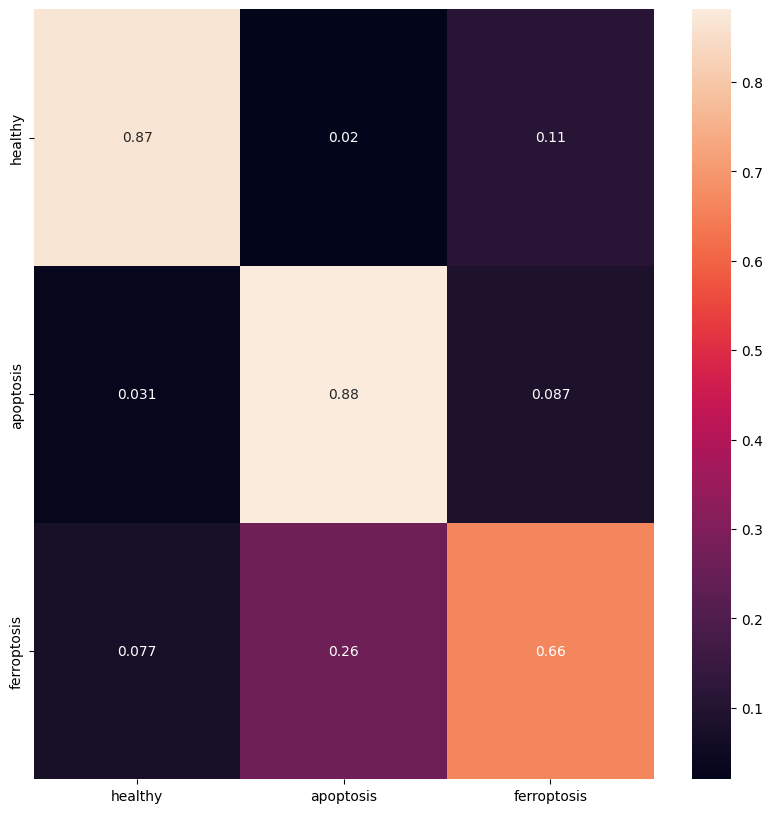

[[24, 0, 1], [54, 0, 1], [59, 0, 1], [65, 0, 1], [71, 0, 1], [94, 1, 2]]
total tie wells 6


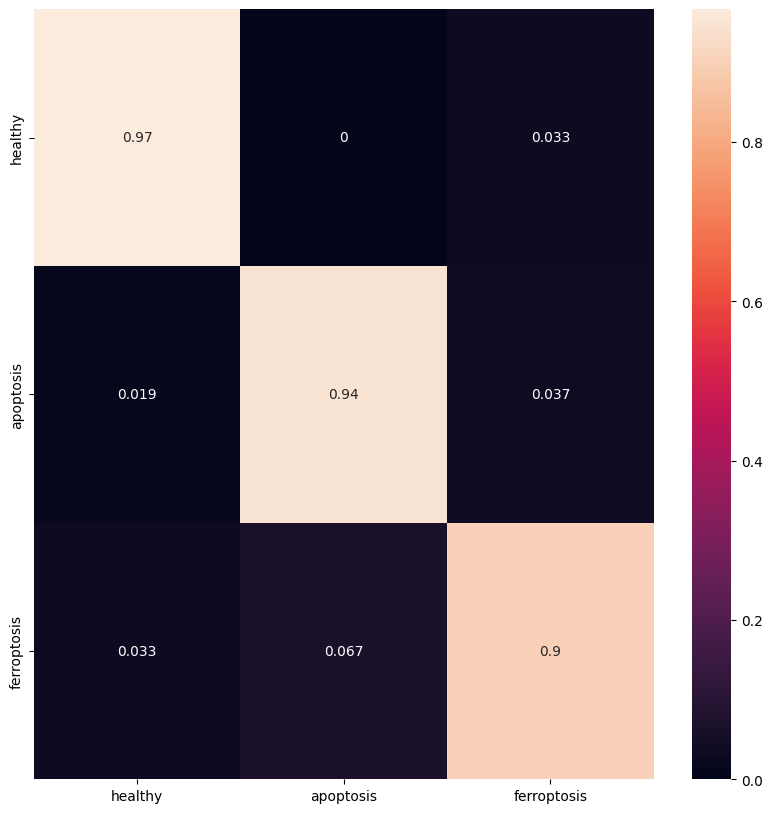

In [65]:
pred_csv = 'test_saved_models_train_exp67_2_pl123_exp8_range2_nonconfocal40_on_dataset_exp8_0.79'

s = 'nonconfocal40'
#num_fields = 3 # 20x images
num_fields = 10 # 40x images
pl = 1 # plate
create_confusion_field_well(f'../saved_predictions/{pred_csv}.csv', prefix_2 = f'exp8_{s}_plate{pl}', 
                            choose_plate=True, plate=pl, save=False, num_fields=num_fields)

## prediction plot

In [67]:
pred_df = create_prediction_df('../saved_predictions/test_saved_models_train_exp67_2_pl123_exp8_all_nonconfocal40_on_dataset_exp8_0.57.csv')

/tmp/ipykernel_104750/3990810282.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pred_df = pred_df.drop('acc', 1)


KeyError: 'concentr'

In [183]:
pred_df

,predicted_labels,ground_truth_labels,plate,truth_decoded,prediction_decoded
0,0,0,1,apoptosis,apoptosis
1,0,0,1,apoptosis,apoptosis
2,0,0,1,apoptosis,apoptosis
3,0,0,1,apoptosis,apoptosis
4,0,0,1,apoptosis,apoptosis
...,...,...,...,...,...
1921,0,1,3,ferroptosis,apoptosis
1922,0,1,3,ferroptosis,apoptosis
1923,0,1,3,ferroptosis,apoptosis
1924,0,1,3,ferroptosis,apoptosis


In [184]:
pred_all = majority_voting(pred_df, num_fields = 3)

[[467, 0, 1, 2], [543, 0, 1, 2], [570, 0, 1, 2], [573, 0, 1, 2], [604, 0, 1, 2]]
total tie wells 5


In [185]:
pred_all

,ground_truth_labels,prediction,truth_decoded,prediction_decoded,tie_well
0,0,0,apoptosis,apoptosis,NaN
1,0,0,apoptosis,apoptosis,NaN
2,0,0,apoptosis,apoptosis,NaN
3,0,0,apoptosis,apoptosis,NaN
4,0,0,apoptosis,apoptosis,NaN
...,...,...,...,...,...
637,1,0,ferroptosis,apoptosis,NaN
638,1,0,ferroptosis,apoptosis,NaN
639,1,0,ferroptosis,apoptosis,NaN
640,1,0,ferroptosis,apoptosis,NaN


In [186]:
#df_all = pd.read_csv('../data_from_CTG_assay/df_exp6_all.csv')
#df_all = pd.read_csv('../data_from_CTG_assay/df_exp7_all.csv')
df_all = pd.read_csv('../data_from_CTG_assay/df_exp8_all.csv')
#df_medium_2 = pd.read_csv('../data_from_CTG_assay/df_concat_exp6_range2.csv')

In [187]:
df_all['concentr'] = df_all['concentr'].str.replace(',', '.')
df_all['concentr'] = pd.to_numeric(df_all["concentr"])

In [188]:
df_all

,Unnamed: 0.1,Unnamed: 0,Row,Col,Treatment,Concentration_uM,Cell_Death,Well,A,incubation_time,drug,Row_New,concentr,normalized_atp_1,plate,B,normalized_atp_2,C,normalized_atp_3
0,0,25,B,1,DMSO,0,Healthy,B01,253624.0,28h,healthy,2,0.000000,1.010063,1,NaN,NaN,NaN,NaN
1,1,26,B,2,Untreated,0,Healthy,B02,251880.0,28h,healthy,2,0.000000,1.003118,1,NaN,NaN,NaN,NaN
2,2,27,B,3,Stauro,"0,04748",Apoptosis,B03,137144.0,28h,apoptosis,2,0.047480,0.546179,1,NaN,NaN,NaN,NaN
3,3,28,B,4,Stauro,"0,02374",Apoptosis,B04,133408.0,28h,apoptosis,2,0.023740,0.531300,1,NaN,NaN,NaN,NaN
4,4,29,B,5,Stauro,"0,01187",Apoptosis,B05,185160.0,28h,apoptosis,2,0.011870,0.737404,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,1003,356,O,20,FIN56,"0,07765",Ferroptosis,O20,NaN,28h,ferroptosis,15,0.077650,NaN,3,NaN,NaN,137784.0,0.548728
1004,1004,357,O,21,FIN56,"0,038825",Ferroptosis,O21,NaN,28h,ferroptosis,15,0.038825,NaN,3,NaN,NaN,181384.0,0.722366
1005,1005,358,O,22,FIN56,"0,0194125",Ferroptosis,O22,NaN,28h,ferroptosis,15,0.019412,NaN,3,NaN,NaN,191168.0,0.761331
1006,1006,359,O,23,DMSO,0,Healthy,O23,NaN,28h,healthy,15,0.000000,NaN,3,NaN,NaN,194032.0,0.772737


In [189]:
df_all = df_all[df_all['drug'] != 'healthy']

In [190]:
df_all.reset_index(drop=True, inplace=True)

In [191]:
df_all

,Unnamed: 0.1,Unnamed: 0,Row,Col,Treatment,Concentration_uM,Cell_Death,Well,A,incubation_time,drug,Row_New,concentr,normalized_atp_1,plate,B,normalized_atp_2,C,normalized_atp_3
0,2,27,B,3,Stauro,"0,04748",Apoptosis,B03,137144.0,28h,apoptosis,2,0.047480,0.546179,1,NaN,NaN,NaN,NaN
1,3,28,B,4,Stauro,"0,02374",Apoptosis,B04,133408.0,28h,apoptosis,2,0.023740,0.531300,1,NaN,NaN,NaN,NaN
2,4,29,B,5,Stauro,"0,01187",Apoptosis,B05,185160.0,28h,apoptosis,2,0.011870,0.737404,1,NaN,NaN,NaN,NaN
3,5,30,B,6,Stauro,"0,005935",Apoptosis,B06,180408.0,28h,apoptosis,2,0.005935,0.718479,1,NaN,NaN,NaN,NaN
4,6,31,B,7,Stauro,"0,0029675",Apoptosis,B07,221344.0,28h,apoptosis,2,0.002968,0.881507,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,1001,354,O,18,FIN56,"0,3106",Ferroptosis,O18,NaN,28h,ferroptosis,15,0.310600,NaN,3,NaN,NaN,68512.0,0.272851
638,1002,355,O,19,FIN56,"0,1553",Ferroptosis,O19,NaN,28h,ferroptosis,15,0.155300,NaN,3,NaN,NaN,59688.0,0.237709
639,1003,356,O,20,FIN56,"0,07765",Ferroptosis,O20,NaN,28h,ferroptosis,15,0.077650,NaN,3,NaN,NaN,137784.0,0.548728
640,1004,357,O,21,FIN56,"0,038825",Ferroptosis,O21,NaN,28h,ferroptosis,15,0.038825,NaN,3,NaN,NaN,181384.0,0.722366


In [192]:
df_all.sort_values(by='normalized_atp_1')

,Unnamed: 0.1,Unnamed: 0,Row,Col,Treatment,Concentration_uM,Cell_Death,Well,A,incubation_time,drug,Row_New,concentr,normalized_atp_1,plate,B,normalized_atp_2,C,normalized_atp_3
175,281,306,M,18,IKE,"1,396",Ferroptosis,M18,8712.0,28h,ferroptosis,13,1.396000,0.034696,1,NaN,NaN,NaN,NaN
165,266,291,M,3,IKE,"1,396",Ferroptosis,M03,9432.0,28h,ferroptosis,13,1.396000,0.037563,1,NaN,NaN,NaN,NaN
170,276,301,M,13,IKE,"1,396",Ferroptosis,M13,10592.0,28h,ferroptosis,13,1.396000,0.042183,1,NaN,NaN,NaN,NaN
187,300,325,N,13,FINO2,"4,284",Ferroptosis,N13,12064.0,28h,ferroptosis,14,4.284000,0.048045,1,NaN,NaN,NaN,NaN
192,305,330,N,18,FINO2,"4,284",Ferroptosis,N18,12536.0,28h,ferroptosis,14,4.284000,0.049925,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,1001,354,O,18,FIN56,"0,3106",Ferroptosis,O18,NaN,28h,ferroptosis,15,0.310600,NaN,3,NaN,NaN,68512.0,0.272851
638,1002,355,O,19,FIN56,"0,1553",Ferroptosis,O19,NaN,28h,ferroptosis,15,0.155300,NaN,3,NaN,NaN,59688.0,0.237709
639,1003,356,O,20,FIN56,"0,07765",Ferroptosis,O20,NaN,28h,ferroptosis,15,0.077650,NaN,3,NaN,NaN,137784.0,0.548728
640,1004,357,O,21,FIN56,"0,038825",Ferroptosis,O21,NaN,28h,ferroptosis,15,0.038825,NaN,3,NaN,NaN,181384.0,0.722366


In [193]:
df_all['prediction_decoded'] = pred_all['prediction_decoded']
df_all['tie_well'] = pred_all['tie_well']

<ipython-input-193-2b95904a00bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['prediction_decoded'] = pred_all['prediction_decoded']
<ipython-input-193-2b95904a00bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['tie_well'] = pred_all['tie_well']


In [194]:
df_all

,Unnamed: 0.1,Unnamed: 0,Row,Col,Treatment,Concentration_uM,Cell_Death,Well,A,incubation_time,...,Row_New,concentr,normalized_atp_1,plate,B,normalized_atp_2,C,normalized_atp_3,prediction_decoded,tie_well
0,2,27,B,3,Stauro,"0,04748",Apoptosis,B03,137144.0,28h,...,2,0.047480,0.546179,1,NaN,NaN,NaN,NaN,apoptosis,NaN
1,3,28,B,4,Stauro,"0,02374",Apoptosis,B04,133408.0,28h,...,2,0.023740,0.531300,1,NaN,NaN,NaN,NaN,apoptosis,NaN
2,4,29,B,5,Stauro,"0,01187",Apoptosis,B05,185160.0,28h,...,2,0.011870,0.737404,1,NaN,NaN,NaN,NaN,apoptosis,NaN
3,5,30,B,6,Stauro,"0,005935",Apoptosis,B06,180408.0,28h,...,2,0.005935,0.718479,1,NaN,NaN,NaN,NaN,apoptosis,NaN
4,6,31,B,7,Stauro,"0,0029675",Apoptosis,B07,221344.0,28h,...,2,0.002968,0.881507,1,NaN,NaN,NaN,NaN,apoptosis,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,1001,354,O,18,FIN56,"0,3106",Ferroptosis,O18,NaN,28h,...,15,0.310600,NaN,3,NaN,NaN,68512.0,0.272851,apoptosis,NaN
638,1002,355,O,19,FIN56,"0,1553",Ferroptosis,O19,NaN,28h,...,15,0.155300,NaN,3,NaN,NaN,59688.0,0.237709,apoptosis,NaN
639,1003,356,O,20,FIN56,"0,07765",Ferroptosis,O20,NaN,28h,...,15,0.077650,NaN,3,NaN,NaN,137784.0,0.548728,apoptosis,NaN
640,1004,357,O,21,FIN56,"0,038825",Ferroptosis,O21,NaN,28h,...,15,0.038825,NaN,3,NaN,NaN,181384.0,0.722366,apoptosis,NaN


In [195]:
di = {'apoptosis': 'A', 'ferroptosis': 'F', 'healthy': 'H'}
df_all['prediction_for_plot'] = df_all['prediction_decoded'].map(di) 

<ipython-input-195-5967a7c53a88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['prediction_for_plot'] = df_all['prediction_decoded'].map(di)


In [196]:
df_all

,Unnamed: 0.1,Unnamed: 0,Row,Col,Treatment,Concentration_uM,Cell_Death,Well,A,incubation_time,...,concentr,normalized_atp_1,plate,B,normalized_atp_2,C,normalized_atp_3,prediction_decoded,tie_well,prediction_for_plot
0,2,27,B,3,Stauro,"0,04748",Apoptosis,B03,137144.0,28h,...,0.047480,0.546179,1,NaN,NaN,NaN,NaN,apoptosis,NaN,A
1,3,28,B,4,Stauro,"0,02374",Apoptosis,B04,133408.0,28h,...,0.023740,0.531300,1,NaN,NaN,NaN,NaN,apoptosis,NaN,A
2,4,29,B,5,Stauro,"0,01187",Apoptosis,B05,185160.0,28h,...,0.011870,0.737404,1,NaN,NaN,NaN,NaN,apoptosis,NaN,A
3,5,30,B,6,Stauro,"0,005935",Apoptosis,B06,180408.0,28h,...,0.005935,0.718479,1,NaN,NaN,NaN,NaN,apoptosis,NaN,A
4,6,31,B,7,Stauro,"0,0029675",Apoptosis,B07,221344.0,28h,...,0.002968,0.881507,1,NaN,NaN,NaN,NaN,apoptosis,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,1001,354,O,18,FIN56,"0,3106",Ferroptosis,O18,NaN,28h,...,0.310600,NaN,3,NaN,NaN,68512.0,0.272851,apoptosis,NaN,A
638,1002,355,O,19,FIN56,"0,1553",Ferroptosis,O19,NaN,28h,...,0.155300,NaN,3,NaN,NaN,59688.0,0.237709,apoptosis,NaN,A
639,1003,356,O,20,FIN56,"0,07765",Ferroptosis,O20,NaN,28h,...,0.077650,NaN,3,NaN,NaN,137784.0,0.548728,apoptosis,NaN,A
640,1004,357,O,21,FIN56,"0,038825",Ferroptosis,O21,NaN,28h,...,0.038825,NaN,3,NaN,NaN,181384.0,0.722366,apoptosis,NaN,A


In [197]:
df_all.loc[df_all['Treatment'] == 'Stauro', 'Treatment'] = 'Staurosporine'

In [48]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
apop_list = ['Staurosporine', 'Vinblastine', 'Paclitaxel', 'Etoposide', 'Actinomycin D', 'Doxorubicin', 'Niclosamide']
#apop_list = ['Stauro', 'Vinblastine', 'Paclitaxel', 'Etoposide', 'Actinomycin D', 'Doxorubicin', 'Niclosamide']
ferrop_list = ['RLS3', 'ML162','ML210', 'Erastin','IKE','FINO2','FIN56']
#healthy_color_key = {'H': 'blue', 'A': 'red', 'F': 'green'} 
healthy_color_key = {'H': 'green', 'A': 'red', 'F': 'blue'}  # for paper

def create_prediction_plot(pred_df, plate, prefix, save=False, color_key = healthy_color_key):
    # will plot for one plate
    fig, axs = plt.subplots(2,7, figsize=(35,10), constrained_layout=True) # number of subplots
    fig.suptitle(f'Plate {plate}')
    # set the font globally
    plt.rcParams.update({'font.family':'sans-serif'})
    # set the font name for a font family
    plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})
    
    plt.rcParams.update({'font.size':14})
    plt.rc('axes', labelsize=14)
    #fig.tight_layout()
    
    axs[0,0].set_ylabel('normalized atp')
    axs[1,0].set_ylabel('normalized atp')
    #axs[0,0].legend(handles=legend_elements)

    unique_labels = ['H', 'A', 'F']
    legend_elements = [Patch(facecolor=color_key[k], label=k) for k in unique_labels]
    fig.legend(handles=legend_elements)
    
    for d in range(len(apop_list)):
        prediction = list(pred_df[(pred_df['plate'] == plate) & (pred_df['Treatment'] == apop_list[d])]['prediction_for_plot'])
        concentrat = list(pred_df[(pred_df['plate'] == plate) & (pred_df['Treatment'] == apop_list[d])]['concentr'])
        atp = list(pred_df[(pred_df['plate'] == plate) & (pred_df['Treatment'] == apop_list[d])][f'normalized_atp_{plate}'])
        
        colors = pd.Series(prediction).map(color_key)
        axs[0,d].scatter(concentrat, atp, c = colors)
        #axs[0,d].scatter(concentrat, atp)
        axs[0,d].set_xscale('log')
        axs[0,d].set_title(f'{apop_list[d]}')
        axs[0,d].set_xlabel('concentration')
        

        for i, txt in enumerate(prediction):
            axs[0,d].annotate(txt, (concentrat[i], atp[i]))
            
    for d in range(len(ferrop_list)):
        prediction = list(pred_df[(pred_df['plate'] == plate) & (pred_df['Treatment'] == ferrop_list[d])]['prediction_for_plot'])
        concentrat = list(pred_df[(pred_df['plate'] == plate) & (pred_df['Treatment'] == ferrop_list[d])]['concentr'])
        atp = list(pred_df[(pred_df['plate'] == plate) & (pred_df['Treatment'] == ferrop_list[d])][f'normalized_atp_{plate}'])
        
        colors = pd.Series(prediction).map(color_key)
        axs[1,d].scatter(concentrat, atp, c = colors)
        #axs[1,d].scatter(concentrat, atp)
        axs[1,d].set_xscale('log')
        axs[1,d].set_title(f'{ferrop_list[d]}')
        axs[1,d].set_xlabel('concentration')

        for i, txt in enumerate(prediction):
            axs[1,d].annotate(txt, (concentrat[i], atp[i]))
     
    if save:
        fig.savefig(f'./saved_figures/prediction_plot_{path_models}_plate{plate}_{prefix}.svg', format = 'svg', dpi = 'figure') 
            
    plt.show() # Depending on whether you use IPython or interactive mode, etc.


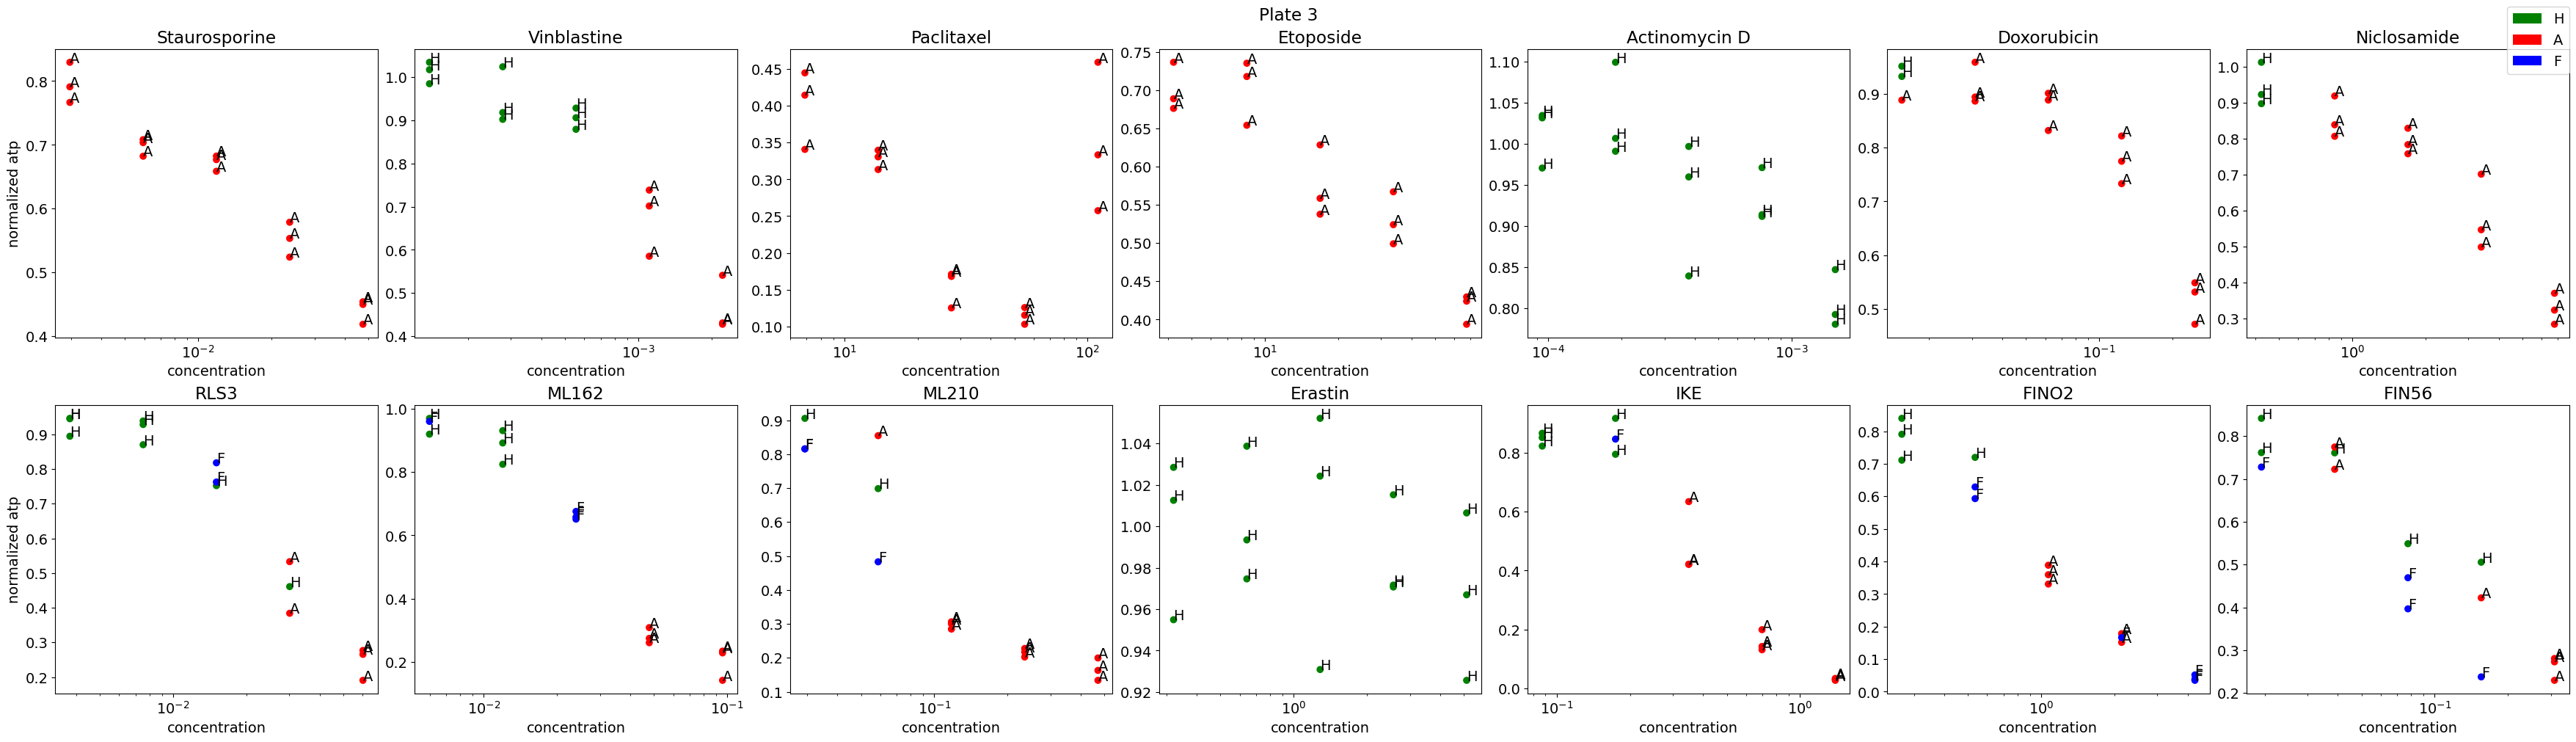

In [51]:
create_prediction_plot(df_all, plate=3, prefix='classifier_all_range_exp8_confocal40_paper_change_colors', save=True)

## umap

In [7]:
from umap.plot import _get_embedding 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def my_plot_umap(umap_obj, decoded_labels_df, label, color_key, title, prefix, save=False):
    points = _get_embedding(umap_obj) #(1264,2)
    #points = umap_obj

    #fig = plt.figure(figsize=(width / dpi, height / dpi))
    #ax = fig.add_subplot(111)
    
    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111)
   
    labels=decoded_labels_df[label]
    print (labels)
    colors = pd.Series(labels).map(color_key)
    print (colors)
    unique_labels = np.unique(labels)
    #unique_labels = ['healthy', 'apoptosis', 'ferroptosis']
    legend_elements = [Patch(facecolor=color_key[k], label=k) for k in unique_labels]

    #plt.subplot(132)
    #size = np.log((decoded_labels_df['true_concentration'])) * 30
    scatter = ax.scatter(points[:, 0], points[:, 1], c = colors, s = 10)
    
    # produce a legend with the unique colors from the scatter
    #legend1 = ax.legend(*scatter.legend_elements(),
                    #loc="upper left", title="Classes")
    #ax.add_artist(legend1)

    ax.legend(handles=legend_elements)
    ax.set_title(title)
    
    if save:
         plt.savefig(f'./saved_figures/umap_{path_models}_{prefix}.png')
            
    return ax

In [8]:
drug_dict = {'DMSO': 'healthy', 'Untreated': 'healthy', 'untreated': 'healthy', 'Actinomycin D': 'apoptosis', 'Vinblastine': 'apoptosis', 
                                                                                       'Vinblastin': 'apoptosis', 'Paclitaxel': 'apoptosis', 
             'Staurosporine': 'apoptosis','Stauro': 'apoptosis','Etoposide': 'apoptosis',
                                                                   'Doxorubicin': 'apoptosis','Niclosamide': 'apoptosis',
                                                                                      'Erastin': 'ferroptosis', 'FIN56': 'ferroptosis', 'FINO2': 'ferroptosis', 
                                                                                       'IKE': 'ferroptosis', 'ML162': 'ferroptosis', 'ML210': 'ferroptosis', 
                                                                                        'RLS3': 'ferroptosis', 'RSL3': 'ferroptosis'}

In [9]:
def get_umap(embs, n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean', densmap=False):
    reducer = umap.UMAP(n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric, densmap=densmap, random_state=42).fit(embs) 
    #tsne = TSNE()
    #reducer = tsne.fit_transform(embs) 
    #%time u = reducer.fit(embs)
    return reducer

In [10]:
import umap.plot
umap.plot.output_notebook()

Loading BokehJS ...

In [11]:
def my_plot_umap_bokeh(reducer, decoded_labels_df, label, color_key, title, save=False, file_name=None):
    ax = umap.plot.interactive(reducer, labels=decoded_labels_df[label], 
                           color_key = color_key, hover_data=decoded_labels_df, point_size=4)
    ax.title.text = title
    umap.plot.show(ax)

In [12]:
# Apoptosis: Staurosporine, Actinomycin D, Paclitaxel, Vinblastin  
# Ferroptosis: Erastin, FIN56, FINO2, IKE, ML162, ML210, RSL3 
apoptosis_color_key = {'DMSO': 'brown', 'Actinomycin D': 'red', 'Vinblastin': 'purple', 'Paclitaxel': 'green', 'Staurosporine': 'blue'} 
ferroptosis_color_key = {'DMSO': 'red', 'Erastin': 'brown', 'FIN56': 'darkgreen', 'FINO2': 'green', 'IKE': 'cyan', 'ML162': 'blue', 'ML210': 'purple', 'RSL3': 'pink'} 
healthy_color_key = {'healthy': 'blue', 'apoptosis': 'red', 'ferroptosis': 'green'} 
healthy_color_key24 = {'Healthy': 'blue', 'Apoptosis': 'red', 'Ferroptosis': 'green'} 
#plates_color_key = {1: 'brown', 2: 'orange', 3: 'lime', 4: 'red', 5: 'blue', 6: 'black'} 
plates_color_key = {1: 'brown', 2: 'orange', 3: 'lime', 4: 'red', 5: 'blue', 6: 'black', 7: 'green', 8: 'magenta', 9: 'violet', 10: 'navy',11: 'cyan',12: 'olive'} 
apop_ferr_color_key = {'Actinomycin D': 'red', 'Vinblastin': 'purple', 'Paclitaxel': 'green', 'Staurosporine': 'blue',
                    'Erastin': 'brown', 'FIN56': 'darkgreen', 'FINO2': 'black', 'IKE': 'cyan', 'ML162': 'magenta', 'ML210': 'darkblue', 'RSL3': 'pink'} 

### medium range2

In [13]:
from ast import literal_eval
def load_embs_df_fields(path):
    embs_df = pd.read_csv(f'{path}')
    #embs_df['embs'] = embs_df['embs'].apply(lambda x: x.replace('[', ''))
    #embs_df['embs'] = embs_df['embs'].apply(lambda x: x.replace(']', ''))
    #embs_df['embs'] = embs_df['embs'].apply(lambda x: x.split())
    embs_df['embs'] = embs_df['embs'].apply(literal_eval)
    #embs_df['embs'] = embs_df['embs'].apply(lambda x: [float(y) for y in x])
    embs_df['embs'] = embs_df['embs'].apply(lambda x: np.array(x))
    return embs_df

In [50]:
#embs_1_df = load_embs_df_fields('embs_exp8_saved_models_train_exp67_2_range2_confocal40.csv')
#embs_1_df = load_embs_df_fields('embs_exp8_saved_models_train_exp67_2_range2_nonconfocal40.csv')
#embs_1_df = load_embs_df_fields('embs_exp8_saved_models_train_exp67_2_range2_nonconfocal20.csv')
#embs_1_df = load_embs_df_fields('embs_exp8_saved_models_train_exp67_2_range2_confocal20.csv')
#embs_1_df = load_embs_df_fields('embs_exp8_saved_models_train_exp67_2_range2_confocal20_zoom_center.csv')
#embs_1_df = load_embs_df_fields('embs_exp8_saved_models_train_exp67_2_range2_nonconfocal20_zoom_center.csv')
embs_1_df = load_embs_df_fields('embs_exp8_saved_models_train_exp67_2_all_nonconfocal40.csv')

In [49]:
embs_1_df

,Unnamed: 0,drug,ground_truth_labels,concentration,plate,drug_name,field,atp,embs
510,510,apoptosis,0,55.1200,1,Paclitaxel,1,0.103291,"[0.007913773879408836, -0.005317888222634792, ..."
511,511,apoptosis,0,55.1200,1,Paclitaxel,2,0.103291,"[0.00436071353033185, -0.0037591205909848213, ..."
512,512,apoptosis,0,55.1200,1,Paclitaxel,3,0.103291,"[0.005340855568647385, -0.0036419471725821495,..."
513,513,apoptosis,0,55.1200,1,Paclitaxel,4,0.103291,"[0.004919687286019325, -0.004990630783140659, ..."
514,514,apoptosis,0,55.1200,1,Paclitaxel,5,0.103291,"[0.005867418833076954, -0.004817877430468798, ..."
...,...,...,...,...,...,...,...,...,...
10025,10025,ferroptosis,1,0.1553,3,FIN56,6,0.237709,"[0.013058925978839397, -0.00523353461176157, -..."
10026,10026,ferroptosis,1,0.1553,3,FIN56,7,0.237709,"[0.01216818392276764, -0.0077430023811757565, ..."
10027,10027,ferroptosis,1,0.1553,3,FIN56,8,0.237709,"[0.016238408163189888, -0.0043722279369831085,..."
10028,10028,ferroptosis,1,0.1553,3,FIN56,9,0.237709,"[0.01689968630671501, -0.006490956526249647, -..."


In [48]:
# only low atp
embs_1_df = embs_1_df[embs_1_df['atp'] < 0.3]

In [51]:
# only high atp
embs_1_df = embs_1_df[embs_1_df['atp'] > 0.8]

In [40]:
# high & low atp
embs_1_df = embs_1_df[(embs_1_df['atp'] < 0.3) | (embs_1_df['atp'] > 0.8)]

In [68]:
embs_1_df[embs_1_df['drug'] == 'ferroptosis']

,Unnamed: 0,drug,ground_truth_labels,concentration,plate,drug_name,field,atp,embs
1700,1700,ferroptosis,1,0.060280,1,RLS3,1,0.159110,"[0.008215523324906826, -0.003031301312148571, ..."
1701,1701,ferroptosis,1,0.060280,1,RLS3,2,0.159110,"[0.007933438755571842, -0.004049297422170639, ..."
1702,1702,ferroptosis,1,0.060280,1,RLS3,3,0.159110,"[0.008322251960635185, -0.004459970165044069, ..."
1703,1703,ferroptosis,1,0.060280,1,RLS3,4,0.159110,"[0.010135880671441555, -0.005945983808487654, ..."
1704,1704,ferroptosis,1,0.060280,1,RLS3,5,0.159110,"[0.007644119206815958, -0.005423066671937704, ..."
...,...,...,...,...,...,...,...,...,...
10055,10055,ferroptosis,1,0.019412,3,FIN56,6,0.761331,"[0.016695814207196236, -0.0054269577376544476,..."
10056,10056,ferroptosis,1,0.019412,3,FIN56,7,0.761331,"[0.011073495261371136, -0.00868974719196558, -..."
10057,10057,ferroptosis,1,0.019412,3,FIN56,8,0.761331,"[0.014931434765458107, -0.0057738893665373325,..."
10058,10058,ferroptosis,1,0.019412,3,FIN56,9,0.761331,"[0.012592200189828873, -0.005690579302608967, ..."


In [48]:
embs_1_df

,Unnamed: 0,drug,ground_truth_labels,concentration,plate,drug_name,field,embs
0,0,apoptosis,0,0.04748,1,Stauro,1,"[0.002754789311438799, -0.0049728029407560825,..."
1,1,apoptosis,0,0.04748,1,Stauro,2,"[0.0016972365556284785, -0.004248575307428837,..."
2,2,apoptosis,0,0.04748,1,Stauro,3,"[0.0037341343704611063, -0.00409830454736948, ..."
3,3,apoptosis,0,0.02374,1,Stauro,1,"[0.0011703720083460212, -0.003913558088243008,..."
4,4,apoptosis,0,0.02374,1,Stauro,2,"[0.003699330845847726, -0.0028088544495403767,..."
...,...,...,...,...,...,...,...,...
1111,1111,healthy,2,0.00000,3,Untreated,2,"[0.016132669523358345, -0.003950306214392185, ..."
1112,1112,healthy,2,0.00000,3,Untreated,3,"[0.013998821377754211, -0.003965897019952536, ..."
1113,1113,healthy,2,0.00000,3,Untreated,1,"[0.01618487387895584, -0.0037606481928378344, ..."
1114,1114,healthy,2,0.00000,3,Untreated,2,"[0.01592428795993328, -0.0033152629621326923, ..."


In [38]:
embs_26 = embs_26_df['embs']
embs_26 = np.stack(embs_26, axis=0)

In [42]:
embs_1 = embs_1_df['embs']
embs_1 = np.stack(embs_1, axis=0)

In [43]:
# take only some drugs
#drugs_select=['Actinomycin D', 'Staurosporine','Paclitaxel', 'Vinblastin','Erastin', 'FIN56', 'FINO2', 'IKE', 'ML162', 'ML210', 'RSL3']
#drugs_select=['DMSO','Untreated', 'Actinomycin D', 'Staurosporine','Paclitaxel', 'Vinblastin','Erastin', 'FIN56', 'FINO2', 'IKE', 'ML162', 'ML210', 'RSL3']
plates_select = [1,2,3]
#plates_select = [1,2,3,4,5,6,7,8,9,10,11,12]
#plates_select = [1,2,3,4,5,6]
#df_subset = decoded_labels_df[decoded_labels_df['drug_name'].isin(drugs_select)]
#df_subset = dec_16_df[dec_16_df['plate'].isin(plates_select)]
#index_list = torch.as_tensor(df_subset.index)

In [184]:
#embs_subset = torch.index_select(embs, 0, index_list)

In [44]:
n_neighbors=20
min_dist=0.0
densmap=False

#title = f'umap of drugs \n medium \n on plates{plates_select} with model {path_models} \n with umap params {n_neighbors} {min_dist} {densmap}'
title = f'umap of drugs \n high & low atp \n on plates{plates_select} with model {path_models} \n with umap params {n_neighbors} {min_dist} {densmap}'
from bokeh.models import Legend, LegendItem
from bokeh.plotting import figure, show

In [41]:
reducer_26 = get_umap(embs_26, n_neighbors, min_dist, densmap=densmap)

In [45]:
reducer_1 = get_umap(embs_1, n_neighbors, min_dist, densmap=densmap)

<AxesSubplot:title={'center':'umap of drugs \n medium \n on plates[1, 2, 3] with model saved_models_train_exp67_2 \n with umap params 20 0.0 False'}>

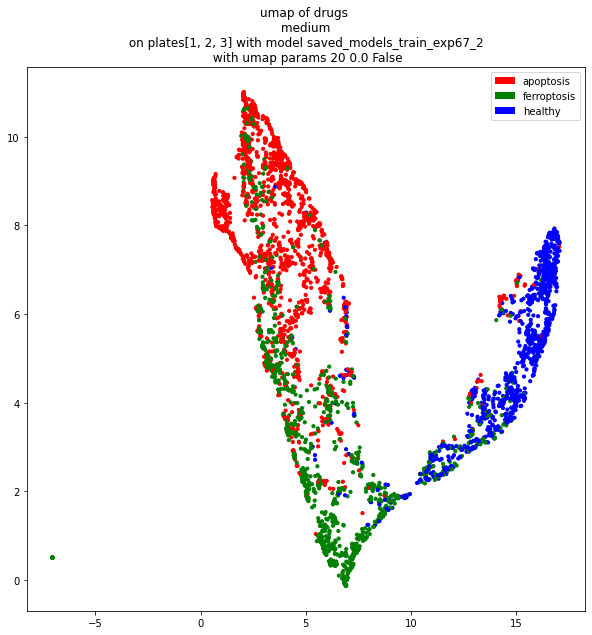

In [230]:
my_plot_umap(reducer_1, embs_1_df, label = 'drug', color_key = healthy_color_key, title=title, prefix='exp8_field_range2_nonconfocal40', save=True)

<AxesSubplot:title={'center':'umap of drugs \n medium \n on plates[1, 2, 3] with model saved_models_train_exp67_2 \n with umap params 20 0.0 False'}>

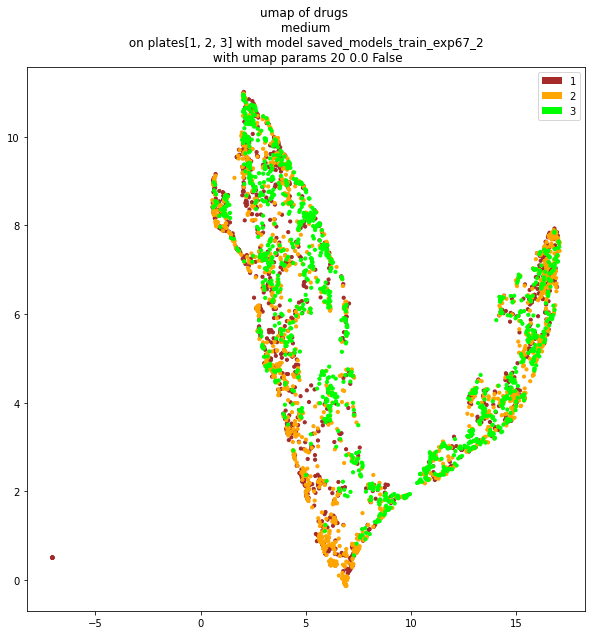

In [231]:
my_plot_umap(reducer_1, embs_1_df, label = 'plate', color_key = plates_color_key, title=title, prefix='exp8_plate_range2_nonconfocal40', save=True)

### all range

In [77]:
my_plot_umap_bokeh(reducer_1, embs_1_df.drop(['embs'], axis=1), label='drug', color_key=healthy_color_key, title=title, save=False, file_name=None)

In [80]:
my_plot_umap_bokeh(reducer_1, embs_1_df.drop(['embs'], axis=1), label='plate', color_key=plates_color_key, title=title, save=False, file_name=None)


0        healthy
1        healthy
2        healthy
3        healthy
4        healthy
          ...   
10075    healthy
10076    healthy
10077    healthy
10078    healthy
10079    healthy
Name: drug, Length: 10080, dtype: object
0        blue
1        blue
2        blue
3        blue
4        blue
         ... 
10075    blue
10076    blue
10077    blue
10078    blue
10079    blue
Name: drug, Length: 10080, dtype: object


TypeError: '<' not supported between instances of 'str' and 'float'

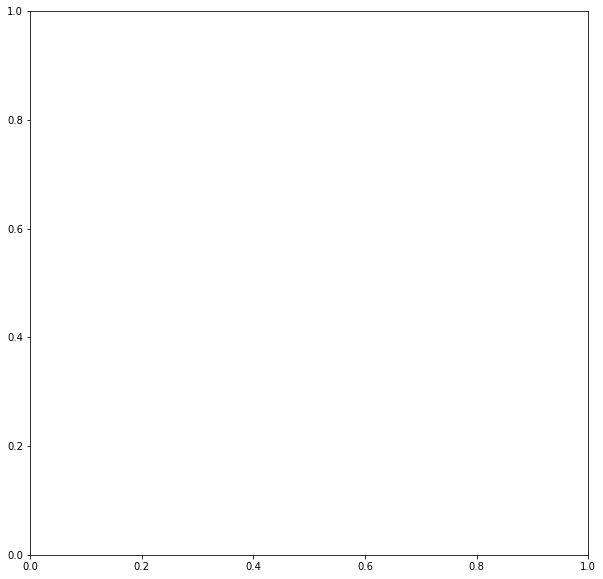

In [82]:
my_plot_umap(reducer_1, embs_1_df, label = 'drug', color_key = healthy_color_key, title=title, prefix='exp8_field_all_nonconfocal40', save=False)